In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import scrublet as scr

import sys
sys.path.append('../')
from mySCfunctions import *
sys.path.append('./')

import Parameters as par
from importlib import reload
reload(par);

import warnings
warnings.filterwarnings('ignore')

In [2]:
a = scp.read("../RawData/Raw.h5ad")

# QC measures

We perform a common quality control wiith the following measures:
 
 1. Number of UMI counts per cell
 2. Number of expressed genes per cell
 3. Number of expressing cells per gene
 4. Mitocondrial fraction
 
It is of relevance to notice that the data extracted from Pijuan and Sala already contains some strict cutoffs over the data:

 1. nCounts > 5000
 2. mtFraction < 2.37%

In [3]:
mtGenesPos = np.array([i for i,j in enumerate(a.var["Gene"]) if "mt-" in j])
mtGenesNames = np.array([j for i,j in enumerate(a.var["Gene"]) if "mt-" in j])

In [4]:
a.obs["nCounts"] = np.array(np.sum(a.X,axis=1))[:,0]
a.obs["nGenes"] = np.array(np.sum(a.X>0,axis=1))[:,0]
a.obs["mtFraction"] = np.array(np.sum(a.X[:,mtGenesPos],axis=1))[:,0]/a.obs["nCounts"]
a.var["nCells"] = np.array(np.sum(a.X>0,axis=0))[0,:]

## UMI counts per cell

The UMI counts had already a high lower cutoff. We do not increase the constrain as it seems to fall in the basin of the bimodality between the removed lower UMI count (<5000) and the proper count distribution.

We do not set any upper bound, in the same way of their analysis. If high count cells are doublets, very probably they will be detected in by the doublet deconvolution procedure we will perform afterwards.

**Bounds:**

$minCounts > 5000$

$maxCounts < 100000$ (effectively $\infty$)

In [5]:
minCounts = 5000
maxCounts = 1000000

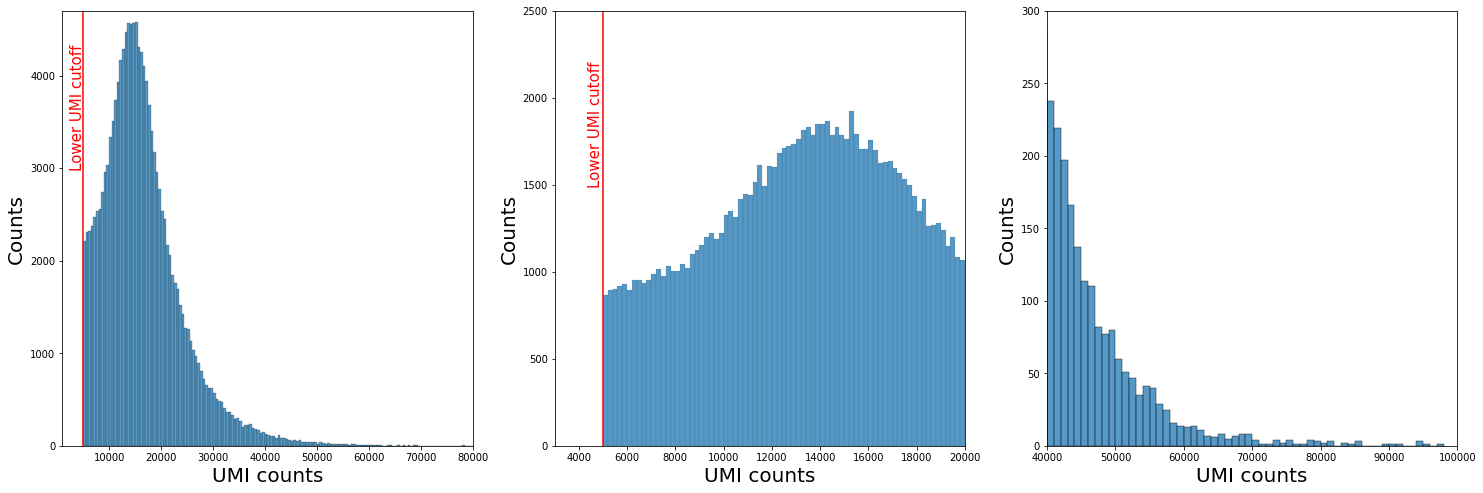

In [6]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

#nCounts
i0 = 0; i1 = None;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=500);
ax[i0].axis([1000,80000,0,4700])
ax[i0].vlines(minCounts,0,5000,color="r")
ax[i0].text(minCounts-2600,3000,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=200);
ax[i0].axis([3000,20000,0,2500])
ax[i0].vlines(minCounts,0,5000,color="r")
ax[i0].text(minCounts-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=1000);
ax[i0].axis([40000,100000,0,300])
#ax[i0,i1].vlines(minCounts,0,5000,color="r")
#ax[i0,i1].text(minCounts-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/QC/UMI_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Gene counts per cell

The number of gene counts show a clear bimodality. This is perfectly normal since the dataset has a very extense variety of cell types with different genetic patterns. We do not constraint at all the distribution at all, as in the analysis of Pijuan and set very loose bounds.

**Bounds:**

$minGenes > 1250$

$maxGenes < 7500$

In [7]:
minGenes = 1250
maxGenes = 7500

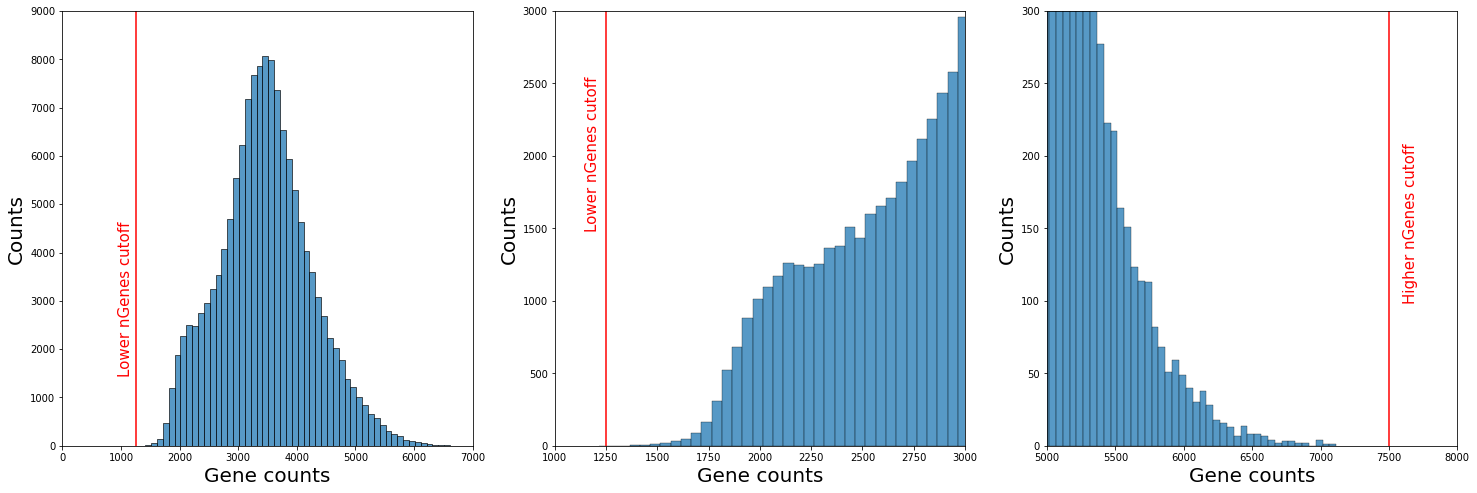

In [8]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

#nGenes
i0 = 0; i1 = 0;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=100);
ax[i0].axis([0,7000,0,9000])
ax[i0].vlines(minGenes,0,10000,color="r")
ax[i0].text(minGenes-300,1500,"Lower nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=50);
ax[i0].axis([1000,3000,0,3000])
ax[i0].vlines(minGenes,0,4000,color="r")
ax[i0].text(minGenes-100,1500,"Lower nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=50);
ax[i0].axis([5000,8000,0,300])
ax[i0].vlines(maxGenes,0,5000,color="r")
ax[i0].text(maxGenes+100,100,"Higher nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/QC/Gene_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Mitochondrial fraction

The dataset has already a predefined upper bound, which will represent dead or dying cells. According to Pijuan's article, after a extremely convoluted process involving clustering the data in a very sloppy way they concluded that they should also remove all cells with a mitochondrial fraction below 0.005.

I consider this process to be very weird and suspicious and simply chose a lower bound according to the bidomal distribution of the mt fraction. This subset if considered to be due to stripped cells, which exploded and only genes from the nuclei are present mostly. 

**Bounds:**

$max MtFraction < 2.38\%$

$min MtFraction > 0.18\%$

**List of mt genes:**

In [9]:
print(mtGenesNames)

['mt-Nd1' 'mt-Nd2' 'mt-Co1' 'mt-Co2' 'mt-Atp8' 'mt-Atp6' 'mt-Co3' 'mt-Nd3'
 'mt-Nd4l' 'mt-Nd4' 'mt-Nd5' 'mt-Nd6' 'mt-Cytb']


Although it is clear that there is a subset of cells that show a extremelly low expression of mitochondrial genes, which will be an indicator of stripped cells, in the original work, this fraction is never removed from the system.

In order to stay as close as possible to the results of the original work, **we will not remove the stipped cells at this point**.

In [10]:
minMtFraction = 0.0025
maxMtFraction = 0.024

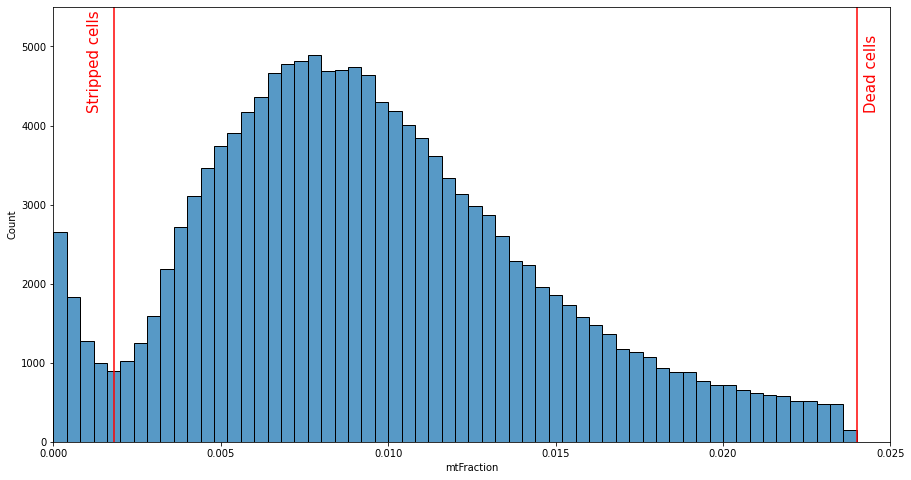

In [11]:
fig,ax = plt.subplots(1,1,figsize=[15,8])

#metFraction
i0 = 3; i1 = 0;
sb.histplot(data=a.obs,x="mtFraction",ax=ax,binwidth=0.0004);
ax.axis([0,0.025,0,5500])
ax.vlines(0.0018,0,6000,color="r")
ax.text(0.001,4200,"Stripped cells",color="red",fontsize=15,rotation="vertical")
ax.vlines(0.024,0,6000,color="r")
ax.text(0.0242,4200,"Dead cells",color="red",fontsize=15,rotation="vertical")

fig.savefig("Plots/QC/mt_fraction.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot of the above limits

From the scatter plot it looks like there is a bimodality. This may happen because a certain set of cells have a different gene expression diversity as other cells. We discuss that in a [section below](#Bimodality). 

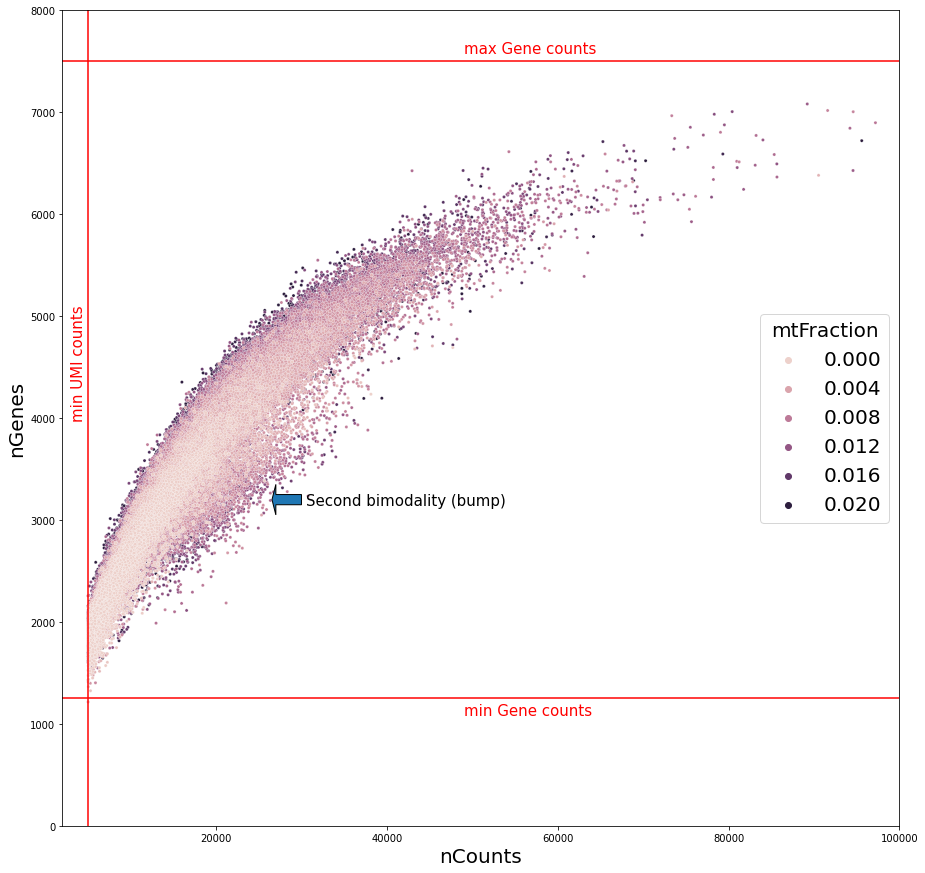

In [12]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 0
data = a.obs.copy()
data.sort_values("mtFraction",inplace=True,ascending=False)
sb.scatterplot(x="nCounts",y="nGenes",hue="mtFraction",data=data,hue_norm=(0,0.02),ax=ax,s=10)
axis = [2000,100000,0,8000]
ax.legend(frameon=True,loc="center right",fontsize=20,title="mtFraction",title_fontsize=20)
ax.axis(axis)
ax.vlines(maxCounts,axis[2],axis[3])
#ax.text(maxCounts,5000,"min UMI count",rotation="vertical")
ax.vlines(minCounts,axis[2],axis[3],color="r")
ax.text(minCounts-(axis[1]-axis[0])*0.02,(axis[3]-axis[2])/2,"min UMI counts",color="r",rotation="vertical",fontsize=15)
ax.hlines(maxGenes,axis[0],axis[1],color="r")
ax.text((axis[1]-axis[0])/2,maxGenes+(axis[3]-axis[2])*0.01,"max Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.hlines(minGenes,axis[0],axis[1],color="r")
ax.text((axis[1]-axis[0])/2,minGenes-(axis[3]-axis[2])*0.02,"min Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.set_xlabel("nCounts",fontsize=20)
ax.set_ylabel("nGenes",fontsize=20)
ax.arrow(30000,3200,-3000,0,width=100)
ax.text(30500,3150,"Second bimodality (bump)",fontsize=15)

fig.savefig("Plots/QC/UMI_Genes_scatter.png",bbox_inches="tight",transparent=True)
fig.show()

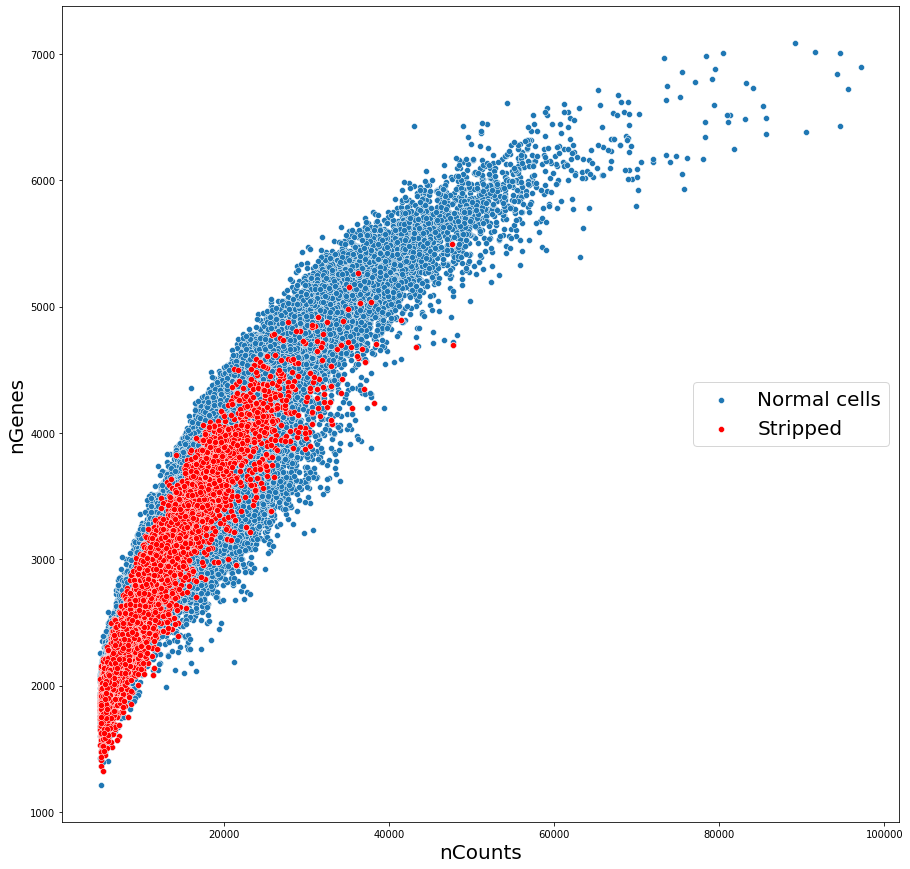

In [13]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 1
sb.scatterplot(x="nCounts",y="nGenes",data=a.obs,ax=ax)
sb.scatterplot(x="nCounts",y="nGenes",color="r",data=a.obs[a.obs["mtFraction"]<minMtFraction],ax=ax)
ax.legend(["Normal cells","Stripped"],frameon=True,loc="center right",fontsize=20)
ax.set_xlabel("nCounts",fontsize=20)
ax.set_ylabel("nGenes",fontsize=20)

fig.savefig("Plots/QC/UMI_Genes_stripped.png",bbox_inches="tight",transparent=True)
fig.show()

## Expressing cells per gene

Since there may be the case that there are very small populations of cells during developmental stages, we will consider a very loose cutoff of the expressing cells and we will remove only those genes that are not expressed at all in the dataset. This is a repetition of the analysis of Pijuan.

**Bounds:**

$nCells < 1$

In [14]:
minCells = 1

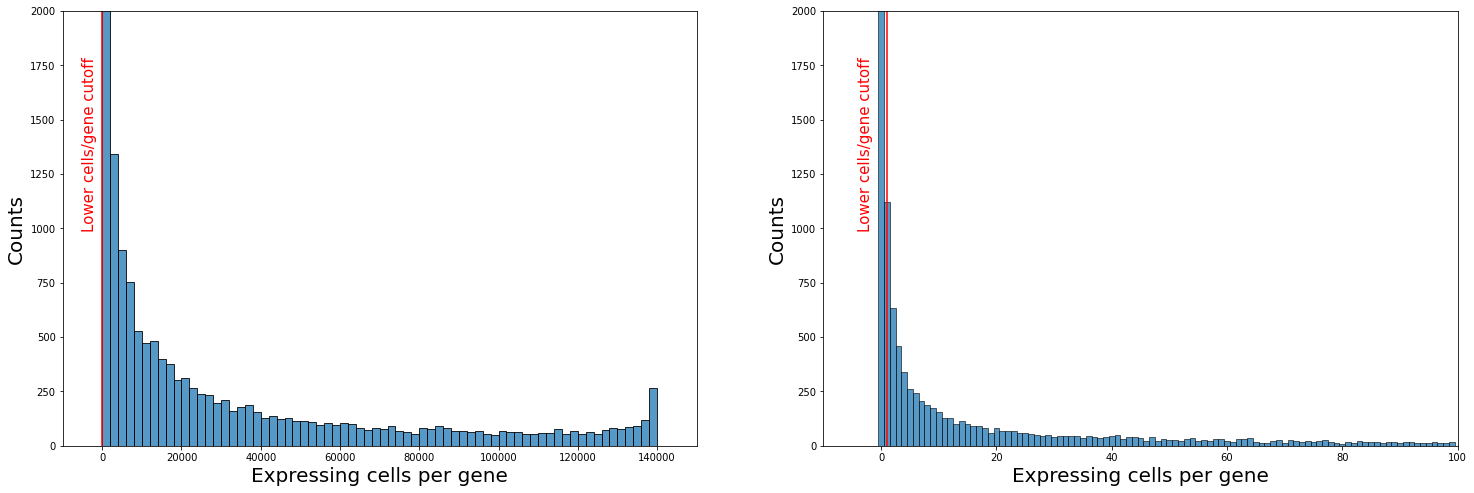

In [15]:
fig,ax = plt.subplots(1,2,figsize=[25,8])

#nCells
i0 = 0;
sb.histplot(data=a.var,x="nCells",ax=ax[i0],binwidth=2000);
ax[i0].axis([-10000,150000,0,2000])
ax[i0].vlines(0,0,5000,color="r")
ax[i0].text(-5000,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

#nCells
i0 = 1;
sb.histplot(data=a.var,x="nCells",ax=ax[i0],bins=np.arange(-.5,100.5,1));
ax[i0].axis([-10,100,0,2000])
ax[i0].vlines(1,0,5000,color="r")
ax[i0].text(-4,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/QC/Cell_counts.png",bbox_inches="tight",transparent=True)
fig.show()

# Plots by samples

We do a quality check over the different samples of the dataset.

From their preprocessing, they already eliminated one sample (11) because showed an anomalous number of cells. But we keep it for sake of consistency with the preprocessing performed in the original paper.

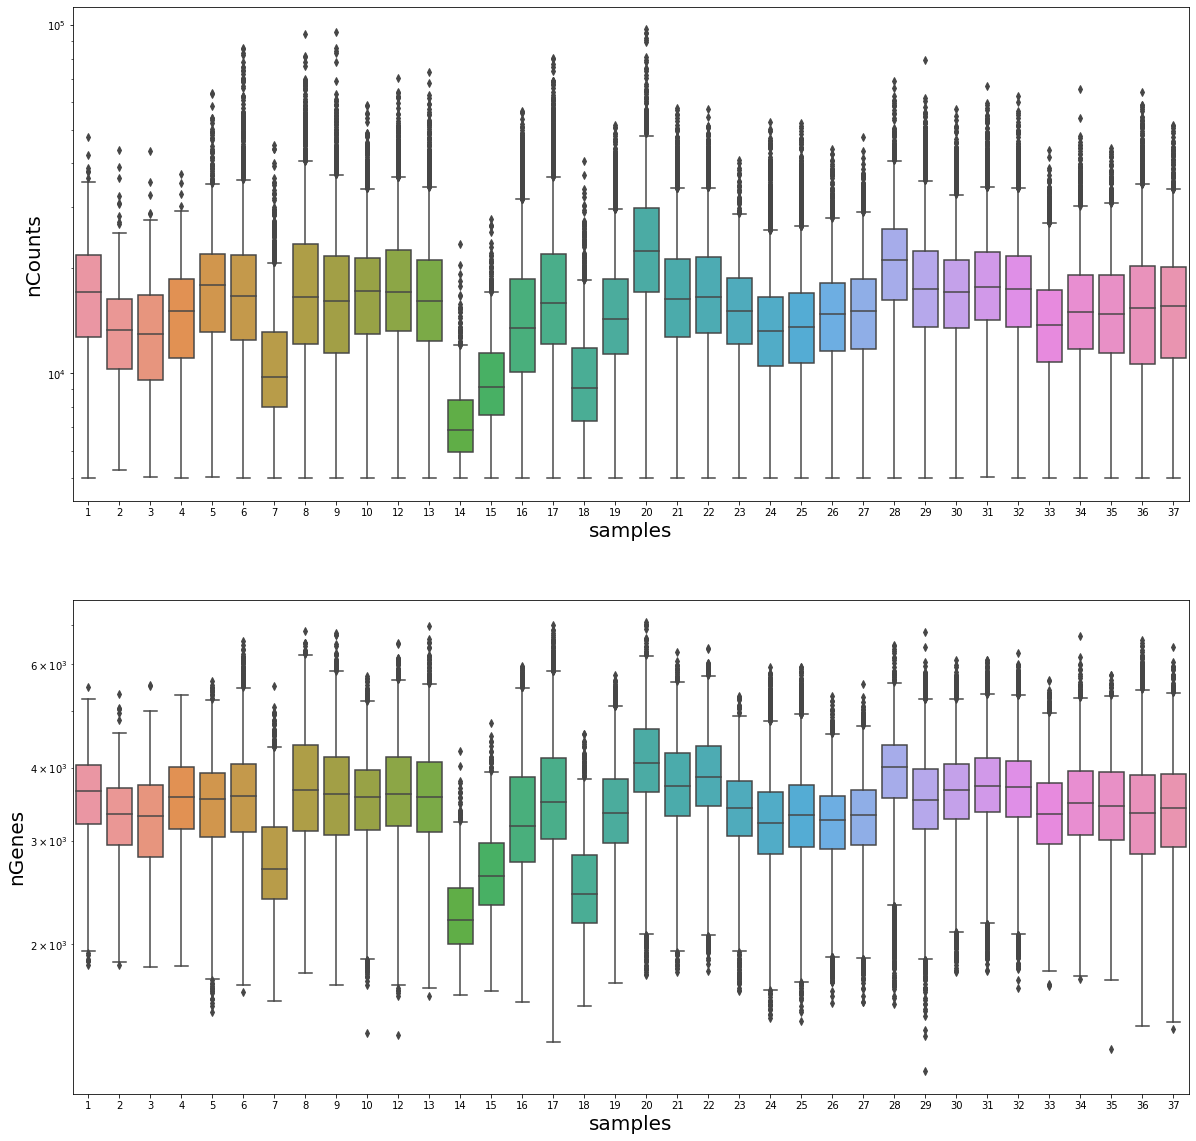

In [16]:
fig,ax = plt.subplots(2,1,figsize=[20,20])

sb.boxplot(y="nCounts",x="sample",data=a.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("nCounts",fontsize=20)

sb.boxplot(y="nGenes",x="sample",data=a.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("nGenes",fontsize=20)

fig.savefig("Plots/QC/UMI_Genes_sample.png",bbox_inches="tight",transparent=True)
fig.show()

# Plots by stages

When plotting against the stages, there does not seem to be bias on the expression and count levels.

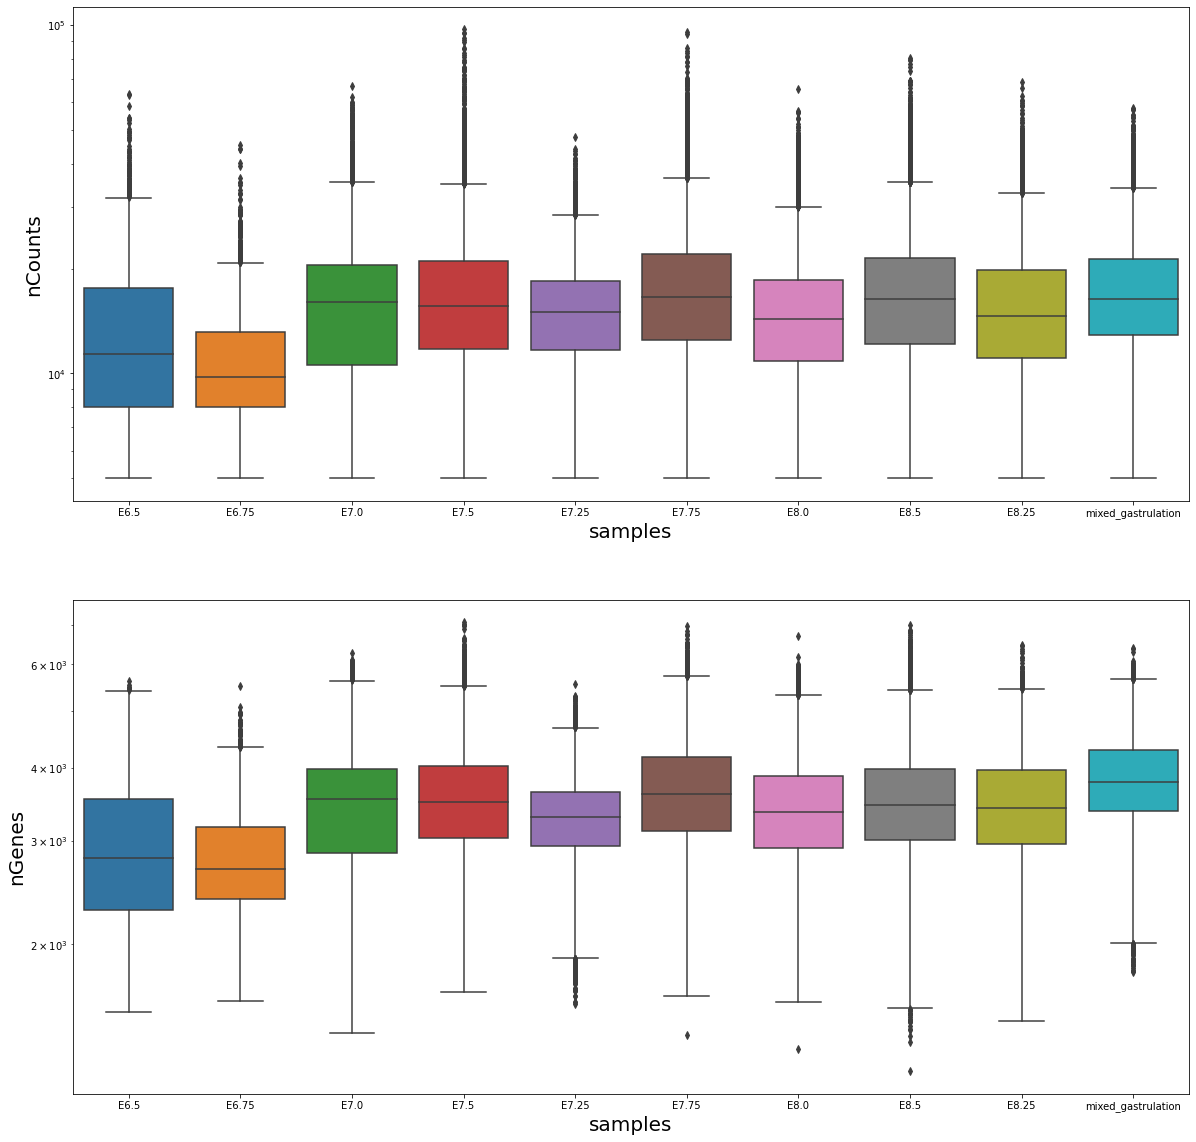

In [17]:
fig,ax = plt.subplots(2,1,figsize=[20,20])

sb.boxplot(y="nCounts",x="stage",data=a.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("nCounts",fontsize=20)

sb.boxplot(y="nGenes",x="stage",data=a.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("nGenes",fontsize=20)

fig.savefig("Plots/QC/UMI_Genes_stage.png",bbox_inches="tight",transparent=True)
fig.show()

<a id='Bimodality'></a>

# Scatter plot bimodality 

As in Pijuan, we look at the gene Hbb-bh1, which is an indicator of blod cell lines. As it can be seen, the second bump in the scatter plot comes from cells expressing the blod cell line indicator and start appearing from the later stages of the development. 

Blod cells show a lower diversity of genes, which is represented in the plots by the second modality at a lower gene expression. This confirms that we are not runing into technical artifacts with the data.

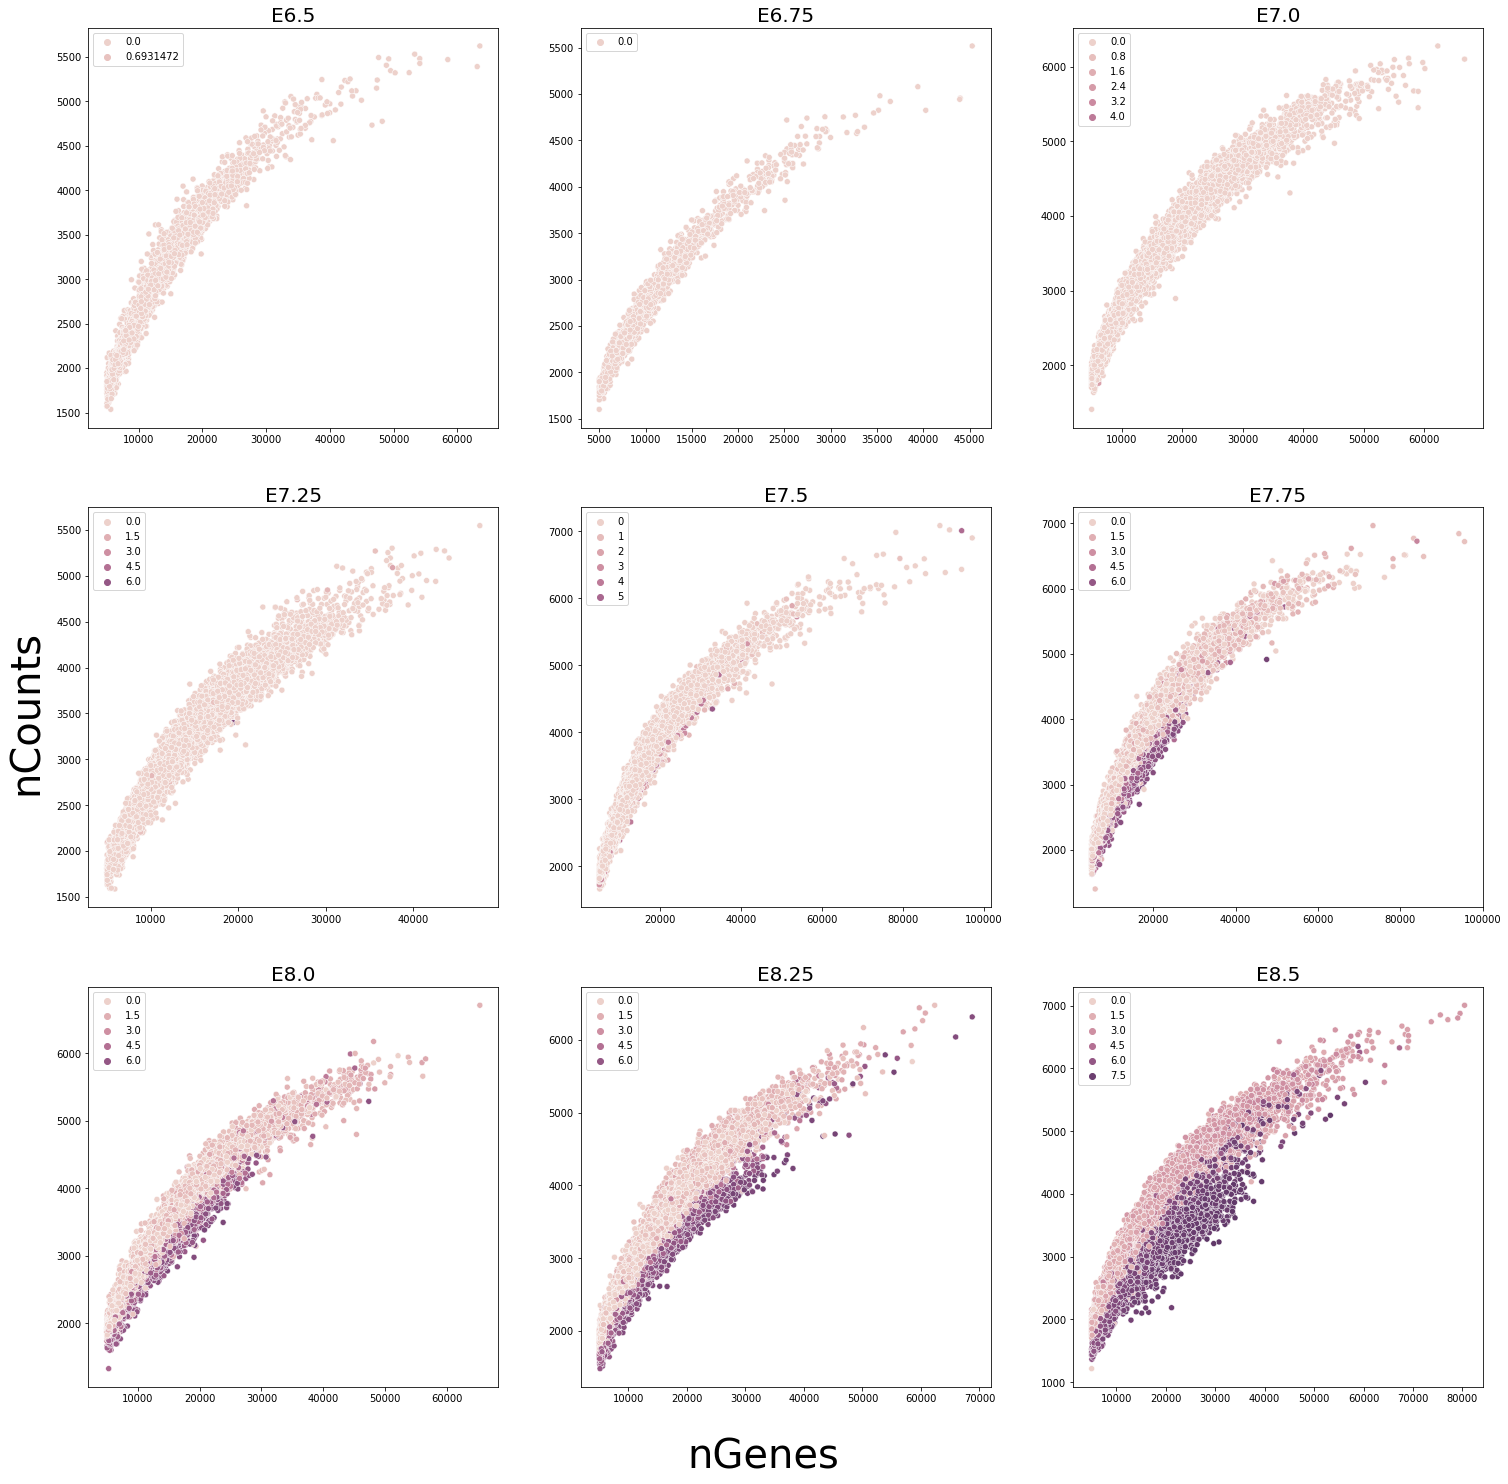

In [18]:
samp = np.sort(a.obs["stage"].values.unique())

fig,ax=plt.subplots(3,3,figsize=[25,25])
m = np.meshgrid(range(3),range(3))
hue = np.log(np.array(a[:,a.var["Gene"]=="Hbb-bh1"].X.todense()).reshape(-1)+1)
for i,j in zip(m[0].reshape(9),m[1].reshape(9)):
    k = 3*i+j
    l = a.obs["stage"]==samp[k]
    sb.scatterplot(x="nCounts",y="nGenes",hue=hue[l],hue_norm=(0,10),data=a.obs[l],ax=ax[i,j])
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    ax[i,j].set_title(str(samp[k]),fontsize=20)#,loc='lower right')
    
fig.text(0.5, 0.08, 'nGenes', ha='center', fontsize=40)
fig.text(0.08, 0.5, 'nCounts', va='center', rotation='vertical', fontsize=40)

fig.savefig("Plots/QC/Second_bimodality.png",bbox_inches="tight",transparent=True)
fig.show()

# Summary QC bounds

In summary, we set the following bounds to the dataset asquality control bounds. 

In [21]:
p = pd.DataFrame(index=["Lower Bound","Upper Bound"])
p["Counts"] = [minCounts,maxCounts]
p["Number genes"] = [minGenes,maxGenes]
p["Exp. genes per cell"] = [minCells,r"$\infty$"]
p["mt fraction"] = [str(minMtFraction)+"*",maxMtFraction]

p.to_csv("Tables/QC/Summary.csv")
p

,Counts,Number genes,Exp. genes per cell,mt fraction
Lower Bound,5000,1250,1,0.0025*
Upper Bound,1000000,7500,$\infty$,0.024


*The lower bound of the mitochonrial fraction is ignored as discussed in the Mitochondrial fraction subsection.

In [22]:
samp = np.sort(np.unique(a.obs["stage"].values))

p = pd.DataFrame(index=samp,columns=["Stage","Counts","Number Genes","mt Fraction","Total","Removed %"])
p = p.astype({"Removed %":float})
for i in samp:
    b = a[a.obs["stage"]==i]
    p.loc[i,"Stage"] = b.obs["stage"].values[0]
    p.loc[i,"Counts"] = b[(b.obs["nCounts"] < minCounts) + (b.obs["nCounts"] > maxCounts)].shape[0]
    p.loc[i,"Number Genes"] = b[(b.obs["nGenes"] < minGenes) + (b.obs["nGenes"] > maxGenes)].shape[0]
    #p.loc[i,"mt Fraction"] = b[(b.obs["mtFraction"] < minMtFraction) + (b.obs["mtFraction"] > maxMtFraction)].shape[0]
    p.loc[i,"mt Fraction"] = b[(b.obs["mtFraction"] > maxMtFraction)].shape[0]
    p.loc[i,"Total"] = b.shape[0]
    p.loc[i,"Removed %"] = (p.loc[i,"Counts"]+p.loc[i,"Number Genes"]+p.loc[i,"mt Fraction"])/b.shape[0]*100

p = p.round({"Removed %":1})
p = p.sort_values("Stage")
p.to_csv("Tables/QC/Summary_removed.csv")
p

,Stage,Counts,Number Genes,mt Fraction,Total,Removed %
E6.5,E6.5,0,0,0,3697,0.0
E6.75,E6.75,0,0,0,2169,0.0
E7.0,E7.0,0,0,0,16571,0.0
E7.25,E7.25,0,0,0,15294,0.0
E7.5,E7.5,0,0,0,12876,0.0
E7.75,E7.75,0,0,0,17720,0.0
E8.0,E8.0,0,0,0,22059,0.0
E8.25,E8.25,0,0,0,18642,0.0
E8.5,E8.5,0,1,0,20978,0.0
mixed_gastrulation,mixed_gastrulation,0,0,0,9325,0.0


In [23]:
scp.pp.filter_cells(a,min_counts=minCounts)
scp.pp.filter_cells(a,max_counts=maxCounts)

scp.pp.filter_cells(a,min_genes=minGenes)
scp.pp.filter_cells(a,max_genes=maxGenes)

scp.pp.filter_genes(a,min_cells=1)

In [24]:
a.write("ManipulatedData/"+par.METRIC+"/QC.h5ad")